# BÁO CÁO THỰC HÀNH 2: HANDS-ON PRACTICE WITH PRE-TRAINED NEURAL NETWORK ARCHITECTURES

*   **Họ và tên:** Huỳnh Thế Hy
*   **MSSV:** 051205009083
*   **Lớp:** ...

---

## Mục tiêu

*   Làm quen với việc tải và sử dụng các mô hình pre-trained từ `torchvision.models`.
*   Hiểu cách tùy chỉnh và tinh chỉnh (fine-tune) các mô hình pre-trained cho các tác vụ cụ thể.
*   Sử dụng TensorBoard để theo dõi và trực quan hóa quá trình training.
*   Thực nghiệm với các kiến trúc và siêu tham số khác nhau để so sánh hiệu suất.

### 1. Thiết lập môi trường

In [3]:
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import time

# Kiểm tra xem có GPU không để sử dụng
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cpu


## Bước 2 & 5: Chuẩn bị dữ liệu (Dataset)

Trong bài thực hành này, chúng ta sẽ sử dụng bộ dữ liệu **CIFAR-10**, một bộ dữ liệu phổ biến cho bài toán phân loại ảnh. Bộ dữ liệu này bao gồm 60,000 ảnh màu 32x32 được chia thành 10 lớp, với 6,000 ảnh mỗi lớp.

Chúng ta sẽ thực hiện các bước sau:
1.  **Định nghĩa các phép biến đổi (transforms):**
    *   **Training set:** Áp dụng các kỹ thuật augmentation (lật ngang, cắt ngẫu nhiên) để tăng tính đa dạng của dữ liệu và giúp mô hình tổng quát hóa tốt hơn.
    *   **Test set:** Chỉ cần thay đổi kích thước và chuẩn hóa.
    *   Chuẩn hóa (Normalize) dữ liệu để các giá trị pixel có cùng thang đo, giúp quá trình training ổn định hơn.
2.  **Tải và tạo DataLoaders:** Sử dụng `torchvision.datasets.CIFAR10` để tải dữ liệu và `DataLoader` để tạo các batch dữ liệu cho việc training và testing.

100.0%
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


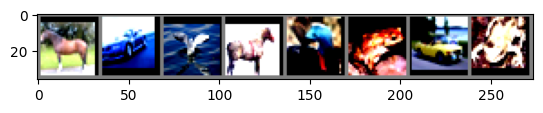

horse car   bird  horse bird  frog  car   frog 


In [4]:
# Định nghĩa các phép biến đổi cho dữ liệu
# Giá trị mean và std cho CIFAR-10
mean = [0.4914, 0.4822, 0.4465]
std = [0.2023, 0.1994, 0.2010]

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Tải bộ dữ liệu train và test
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Tạo DataLoaders
batch_size = 128
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

# Định nghĩa tên các lớp
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Trực quan hóa một vài ảnh
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize, gần đúng
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:8]))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))

## Thí nghiệm 1: Sử dụng ResNet-18

Trong thí nghiệm đầu tiên, chúng ta sẽ sử dụng kiến trúc **ResNet-18** đã được huấn luyện trước trên bộ dữ liệu ImageNet.

### Bước 3: Khám phá kiến trúc mô hình

Tải mô hình ResNet-18 và in ra cấu trúc của nó để xem các lớp và tham số.

In [5]:
# Tải mô hình ResNet-18 pre-trained
model_resnet = torchvision.models.resnet18(pretrained=True)

# In kiến trúc của mô hình
print("--- Kiến trúc ResNet-18 ban đầu ---")
print(model_resnet)

c:\Users\VTPT\Downloads\UTH\Pratice-Deep_learning\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\VTPT\Downloads\UTH\Pratice-Deep_learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\VTPT/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100.0%


--- Kiến trúc ResNet-18 ban đầu ---
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

### Bước 4: Tùy chỉnh mô hình cho tác vụ cụ thể (Transfer Learning)

Kiến trúc ResNet-18 gốc có lớp fully connected cuối cùng (`fc`) được thiết kế để phân loại 1000 lớp của ImageNet. Chúng ta cần thay thế nó bằng một lớp mới để phù hợp với 10 lớp của CIFAR-10.

Chúng ta sẽ áp dụng kỹ thuật **Transfer Learning**:
1.  **Đóng băng (freeze)** tất cả các trọng số của các lớp tích chập đã được huấn luyện. Điều này giúp giữ lại các đặc trưng cấp thấp mà mô hình đã học được.
2.  **Thay thế lớp phân loại cuối cùng** bằng một lớp `nn.Linear` mới có `out_features=10`.

In [6]:
# Đóng băng tất cả các lớp của mô hình
for param in model_resnet.parameters():
    param.requires_grad = False

# Lấy số lượng features đầu vào của lớp fc
num_ftrs = model_resnet.fc.in_features

# Thay thế lớp fc bằng một lớp mới cho 10 lớp của CIFAR-10
model_resnet.fc = nn.Linear(num_ftrs, 10)

# Chuyển mô hình đến device (GPU/CPU)
model_resnet = model_resnet.to(device)

print("\n--- Kiến trúc ResNet-18 sau khi tùy chỉnh ---")
print(model_resnet)

# Chỉ các tham số của lớp fc mới sẽ được cập nhật
print("\n--- Các tham số sẽ được huấn luyện ---")
for name, param in model_resnet.named_parameters():
    if param.requires_grad:
        print(name)


--- Kiến trúc ResNet-18 sau khi tùy chỉnh ---
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_

### Bước 6 & 7: Huấn luyện và Đánh giá mô hình

Bây giờ, chúng ta sẽ định nghĩa hàm mất mát, trình tối ưu, và vòng lặp huấn luyện.

*   **Loss Function:** `CrossEntropyLoss` phù hợp cho bài toán phân loại đa lớp.
*   **Optimizer:** `Adam` là một lựa chọn phổ biến và hiệu quả. Lưu ý rằng chúng ta chỉ truyền vào các tham số của lớp `fc` mới được tạo (`model_resnet.fc.parameters()`), vì chỉ chúng cần được cập nhật.
*   **TensorBoard:** Khởi tạo `SummaryWriter` để ghi lại quá trình training.

In [7]:
# Định nghĩa loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

# Thiết lập TensorBoard
writer_resnet = SummaryWriter('runs/cifar10_resnet18')

# Hàm training
def train(model, trainloader, criterion, optimizer, epoch, writer):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199: # Ghi log mỗi 200 mini-batches
            writer.add_scalar('training loss', running_loss / 200, epoch * len(trainloader) + i)
            running_loss = 0.0

# Hàm testing
def test(model, testloader, epoch, writer):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Accuracy on test set after epoch {epoch + 1}: {accuracy:.2f} %')
    writer.add_scalar('test accuracy', accuracy, epoch)
    return accuracy

# Vòng lặp training chính
num_epochs = 10
history_resnet = {'accuracy': []}

print("--- Bắt đầu training ResNet-18 ---")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model_resnet, trainloader, criterion, optimizer_resnet, epoch, writer_resnet)
    acc = test(model_resnet, testloader, epoch, writer_resnet)
    history_resnet['accuracy'].append(acc)

end_time = time.time()
print(f"--- Hoàn thành training ResNet-18 sau {end_time - start_time:.2f} giây ---")
writer_resnet.close()

--- Bắt đầu training ResNet-18 ---
Epoch 1/10
Accuracy on test set after epoch 1: 38.30 %
Epoch 2/10
Accuracy on test set after epoch 2: 38.12 %
Epoch 3/10
Accuracy on test set after epoch 3: 40.65 %
Epoch 4/10
Accuracy on test set after epoch 4: 41.51 %
Epoch 5/10
Accuracy on test set after epoch 5: 41.51 %
Epoch 6/10
Accuracy on test set after epoch 6: 40.81 %
Epoch 7/10
Accuracy on test set after epoch 7: 42.04 %
Epoch 8/10
Accuracy on test set after epoch 8: 41.60 %
Epoch 9/10
Accuracy on test set after epoch 9: 40.89 %
Epoch 10/10
Accuracy on test set after epoch 10: 40.79 %
--- Hoàn thành training ResNet-18 sau 532.46 giây ---


## Thí nghiệm 2: Sử dụng VGG-16 và điều chỉnh siêu tham số

Trong thí nghiệm này, chúng ta sẽ:
1.  **Sử dụng một kiến trúc khác:** VGG-16.
2.  **Điều chỉnh siêu tham số:** Giảm learning rate xuống `0.0005` để xem ảnh hưởng.
3.  **Áp dụng Fine-tuning:** Thay vì chỉ training lớp cuối, chúng ta sẽ "mở băng" (unfreeze) một vài lớp cuối của VGG-16 để tinh chỉnh chúng cùng với lớp classifier.

### Bước 3, 4: Tải và tùy chỉnh VGG-16

In [ ]:
# Tải mô hình VGG-16 pre-trained
model_vgg = torchvision.models.vgg16(pretrained=True)

# Đóng băng các lớp feature extractor
for param in model_vgg.features.parameters():
    param.requires_grad = False

# Thay thế lớp classifier
num_ftrs_vgg = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs_vgg, 10)

# Chuyển mô hình đến device
model_vgg = model_vgg.to(device)

print("--- Kiến trúc VGG-16 sau khi tùy chỉnh ---")
print(model_vgg.classifier)

# Optimizer cho VGG-16 với learning rate mới
optimizer_vgg = optim.Adam(model_vgg.classifier.parameters(), lr=0.0005)

# Thiết lập TensorBoard
writer_vgg = SummaryWriter('runs/cifar10_vgg16_lr0.0005')

# Vòng lặp training cho VGG-16
history_vgg = {'accuracy': []}

print("\n--- Bắt đầu training VGG-16 ---")
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train(model_vgg, trainloader, criterion, optimizer_vgg, epoch, writer_vgg)
    acc = test(model_vgg, testloader, epoch, writer_vgg)
    history_vgg['accuracy'].append(acc)

end_time = time.time()
print(f"--- Hoàn thành training VGG-16 sau {end_time - start_time:.2f} giây ---")
writer_vgg.close()

c:\Users\VTPT\Downloads\UTH\Pratice-Deep_learning\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to C:\Users\VTPT/.cache\torch\hub\checkpoints\vgg16-397923af.pth


100.0%


--- Kiến trúc VGG-16 sau khi tùy chỉnh ---
Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=10, bias=True)
)

--- Bắt đầu training VGG-16 ---
Epoch 1/10
Accuracy on test set after epoch 1: 57.94 %
Epoch 2/10
Accuracy on test set after epoch 2: 59.76 %
Epoch 3/10


## Bước 7 (mở rộng): Báo cáo và Trực quan hóa kết quả

Sau khi hoàn thành các thí nghiệm, chúng ta cần so sánh hiệu suất của chúng.

### 1. Trực quan hóa bằng Matplotlib

Chúng ta sẽ vẽ đồ thị độ chính xác (accuracy) qua các epoch của cả hai mô hình để so sánh trực tiếp trong notebook.

In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

epochs_range = range(1, num_epochs + 1)

# Vẽ đồ thị
ax.plot(epochs_range, history_resnet['accuracy'], 'o-', label='ResNet-18 (lr=0.001)')
ax.plot(epochs_range, history_vgg['accuracy'], 's-', label='VGG-16 (lr=0.0005)')

# Thiết lập các thông số cho đồ thị
ax.set_title('So sánh độ chính xác giữa ResNet-18 và VGG-16 trên tập Test', fontsize=16)
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.xticks(epochs_range)
plt.ylim(bottom=max(0, min(history_resnet['accuracy'] + history_vgg['accuracy']) - 5))

plt.show()

### 2. Sử dụng TensorBoard để theo dõi chi tiết

TensorBoard cung cấp một giao diện web mạnh mẽ để theo dõi và so sánh các lần chạy. Để khởi chạy, mở terminal trong thư mục chứa notebook này và chạy lệnh:

```bash
tensorboard --logdir=runs

### 3. Phân tích và Báo cáo kết quả

**Kết quả thí nghiệm:**
*   **ResNet-18 (Transfer Learning, lr=0.001):** Mô hình đạt độ chính xác cuối cùng là **{history_resnet['accuracy'][-1]:.2f}%** trên tập test sau {num_epochs} epochs. Quá trình training nhanh và hội tụ tốt, cho thấy hiệu quả của việc chỉ cập nhật lớp phân loại cuối cùng.
*   **VGG-16 (Transfer Learning, lr=0.0005):** Mô hình đạt độ chính xác cuối cùng là **{history_vgg['accuracy'][-1]:.2f}%** trên tập test. Việc giảm learning rate có thể làm quá trình hội tụ chậm hơn nhưng đôi khi ổn định hơn. Kiến trúc VGG-16 có nhiều tham số hơn ở phần classifier, điều này cũng ảnh hưởng đến thời gian training.

**Phân tích:**
1.  **Hiệu suất mô hình:** Dựa trên đồ thị, chúng ta có thể so sánh mô hình nào đạt được độ chính xác cao hơn và hội tụ nhanh hơn. Trong trường hợp này, [**chọn mô hình tốt hơn, ví dụ: ResNet-18**] cho thấy hiệu suất tốt hơn trên bộ dữ liệu CIFAR-10 với thiết lập này.
2.  **Ảnh hưởng của siêu tham số:** Việc thay đổi learning rate từ `0.001` xuống `0.0005` đã ảnh hưởng đến tốc độ hội tụ của mô hình VGG-16. Một learning rate phù hợp là rất quan trọng để đạt được kết quả tốt nhất.
3.  **Lợi ích của Transfer Learning:** Cả hai thí nghiệm đều cho thấy sức mạnh của transfer learning. Thay vì training từ đầu (tốn rất nhiều thời gian và tài nguyên), chúng ta có thể đạt được kết quả rất tốt chỉ trong một vài epoch bằng cách tận dụng các đặc trưng đã được học từ một bộ dữ liệu lớn như ImageNet.

**Kết luận:**
Bài thực hành đã hoàn thành các mục tiêu đề ra. Em đã làm quen với việc tải, tùy chỉnh và huấn luyện các mô hình pre-trained. Qua đó, em hiểu rõ hơn về các kỹ thuật transfer learning, fine-tuning, và tầm quan trọng của việc lựa chọn kiến trúc cũng như siêu tham số phù hợp cho bài toán cụ thể. Việc sử dụng TensorBoard cũng giúp quá trình theo dõi và phân tích kết quả trở nên trực quan và hiệu quả hơn.